**#using an artificial recurrent neural network called long short term memory (LSTM) to predict the close price of idea-vodafone using the past 60 days stock price.**

In [122]:
import math
import pandas_datareader as pdr
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


In [123]:
#get the stock price
df = pdr.DataReader("IDEA.NS", data_source="yahoo", start="2010-03-25", end="2020-08-31")
df.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-03-25,40.760700,39.102501,39.193001,40.127602,9830780.0,39.102074
2010-03-26,40.489399,39.856300,40.157700,40.217999,3616226.0,39.190155
2010-03-29,41.062199,39.886398,40.097401,40.459202,5626010.0,39.425198
2010-03-30,40.790901,39.705502,40.700401,40.157700,5431874.0,39.131401
2010-03-31,40.459202,39.283401,40.459202,39.494499,4386575.0,38.485149


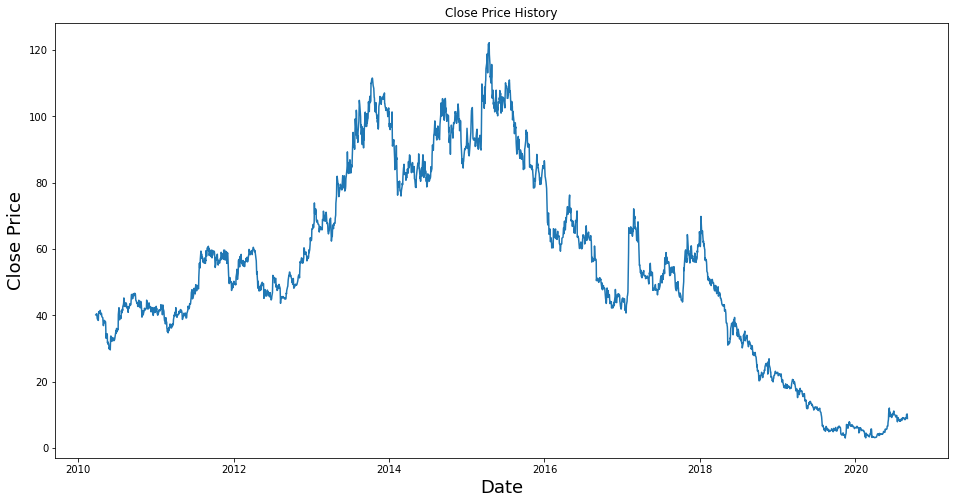

In [124]:
#visualize the close price history
plt.figure(figsize=(16,8))
plt.title("Close Price History")
plt.plot(df['Close'])
plt.xlabel('Date', fontsize =18)
plt.ylabel('Close Price', fontsize = 18)
plt.show()

In [125]:
#create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
print(data.tail(5))
train_size = math.ceil(len(data)*0.7)
print(train_size,len(data)-train_size)
test_data = data.iloc[train_size:,:]
test_data.tail(5)

            Close
Date             
2020-08-26   8.90
2020-08-27   8.85
2020-08-28  10.10
2020-08-31  10.20
2020-09-01   8.85
1802 772


,Close
Date,
2020-08-26,8.90
2020-08-27,8.85
2020-08-28,10.10
2020-08-31,10.20
2020-09-01,8.85


In [126]:
#scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(np.array(data).reshape(-1,1))
#scaled_data
train_data = scaled_data[:train_size,:]
test_data = scaled_data[train_size:,:]

In [127]:
time_stamp = 60
train_data = scaled_data[0:train_size, :]
x_train = []
y_train = []
for i in range(time_stamp,len(train_data)):
  x_train.append(train_data[i-time_stamp:i,0])
  y_train.append(train_data[i,0])

In [128]:
#convert the x_train and y_train to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

In [129]:
#reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1742, 60, 1)

In [130]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import TimeDistributed

In [131]:
#build the LSTM model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(75))
model.add(Dense(25))
model.add(Dense(1))

In [132]:
#compile the model
model.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])

In [133]:
#train the model
model.fit(x_train, y_train, batch_size=4, epochs=300,verbose=1,validation_split=0.25)

Epoch 1/300
327/327 [==============================] - 4s 11ms/step - loss: 0.0036 - accuracy: 7.6570e-04 - val_loss: 8.7309e-04 - val_accuracy: 0.0000e+00
Epoch 2/300
327/327 [==============================] - 3s 9ms/step - loss: 0.0011 - accuracy: 7.6570e-04 - val_loss: 7.9931e-04 - val_accuracy: 0.0000e+00
Epoch 3/300
327/327 [==============================] - 3s 9ms/step - loss: 0.0012 - accuracy: 7.6570e-04 - val_loss: 7.4985e-04 - val_accuracy: 0.0000e+00
Epoch 4/300
327/327 [==============================] - 3s 9ms/step - loss: 7.4825e-04 - accuracy: 7.6570e-04 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 5/300
327/327 [==============================] - 3s 9ms/step - loss: 6.8780e-04 - accuracy: 7.6570e-04 - val_loss: 9.8547e-04 - val_accuracy: 0.0000e+00
Epoch 6/300
327/327 [==============================] - 3s 9ms/step - loss: 5.7999e-04 - accuracy: 7.6570e-04 - val_loss: 5.1759e-04 - val_accuracy: 0.0000e+00
Epoch 7/300
327/327 [==============================] - 3s 9ms

In [134]:
from keras.models import model_from_json
import os
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")

In [135]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

model.load_weights("model.h5")

In [136]:
#create the test dataset
#create a new array containing scaled values from index 464 to 655
test_data = scaled_data[train_size - time_stamp:,:]
#create the dataset x_test and y_test
x_test = []
dataset = df.values
y_test = dataset[train_size:,:]
for i in range(time_stamp, len(test_data)):
  x_test.append(test_data[i-time_stamp:i,0])

In [137]:
#x_test.shape
y_test.shape

(772, 6)

In [138]:
#convert the data to a numpy array
x_test = np.array(x_test)

In [139]:
#reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [140]:
#get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
#predictions = predictions[:712]
predictions.shape,y_test.shape

((772, 1), (772, 6))

In [142]:
#plot the data
train = data[:train_size]
valid = data[train_size:]
valid['Predictions'] = predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


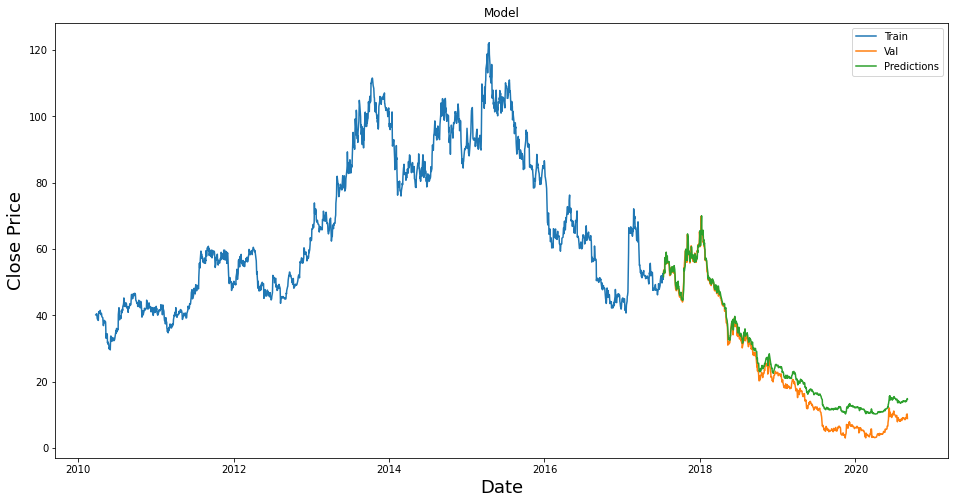

In [143]:
#visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize = 18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
plt.show()

In [144]:
#get the quote
idea_quote = pdr.DataReader('IDEA.NS', data_source='yahoo', start='2020-03-25', end='2020-08-31')
#create a new dataframe
new_df= idea_quote.filter(['Close'])
#get the last 60 days closing price values and convert the dataframe to an array
last_60_days = new_df[-60:].values
#scale the data to be values between 0 and 1
last_60_days_scaled= scaler.transform(last_60_days)
#create an empty list
X_test = []
#append the past 60 days
X_test.append(last_60_days_scaled)
#convert the X_test data set to a numpy array
X_test = np.array(X_test)
#reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#get the predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[14.028273]]


In [145]:
#get the quote
idea_quote2 = pdr.DataReader('IDEA.NS', data_source='yahoo', start='2020-08-31', end ='2020-08-31')
print(idea_quote2['Close'])

Date
2020-08-31    10.20
2020-09-01     8.85
Name: Close, dtype: float64


In [146]:
test_len = len(test_data)
test_len

832

In [147]:
look_back = 60
x_input=test_data[test_len - look_back:].reshape(1,-1)
x_input.shape

(1, 60)

In [148]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [149]:
from numpy import array

lst_output=[]
n_steps=60
i=0
y_shape = 30

while(i<y_shape):
    
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        #print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
print(lst_output)

[0.09285907]
1 day output [[0.12403835]]
2 day output [[0.13716537]]
3 day output [[0.14761418]]
4 day output [[0.16163318]]
5 day output [[0.17382142]]
6 day output [[0.18547985]]
7 day output [[0.19771841]]
8 day output [[0.20967229]]
9 day output [[0.22138065]]
10 day output [[0.23286617]]
11 day output [[0.24367857]]
12 day output [[0.2535444]]
13 day output [[0.26238135]]
14 day output [[0.27018997]]
15 day output [[0.27710658]]
16 day output [[0.28335157]]
17 day output [[0.28913587]]
18 day output [[0.29461402]]
19 day output [[0.29985955]]
20 day output [[0.30486536]]
21 day output [[0.30957484]]
22 day output [[0.31392604]]
23 day output [[0.31789047]]
24 day output [[0.32149473]]
25 day output [[0.32481796]]
26 day output [[0.32796925]]
27 day output [[0.33105564]]
28 day output [[0.33415294]]
29 day output [[0.33729094]]
[[0.09285906702280045], [0.12403835356235504], [0.137165367603302], [0.14761418104171753], [0.1616331785917282], [0.17382141947746277], [0.18547984957695007

In [150]:
future = 30
df1 = scaled_data
day_new=np.arange(1,1+look_back)
day_pred=np.arange(1+look_back,1+look_back+future)
len(df1)

2574

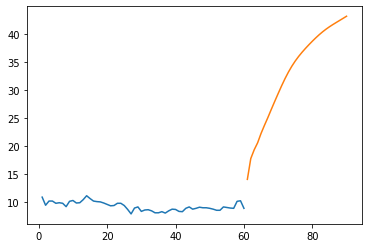

In [151]:
plt.plot(day_new,scaler.inverse_transform(df1[len(df1)-look_back:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

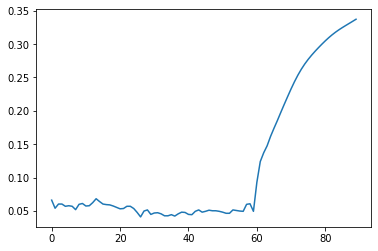

In [152]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[len(df1)-n_steps:])

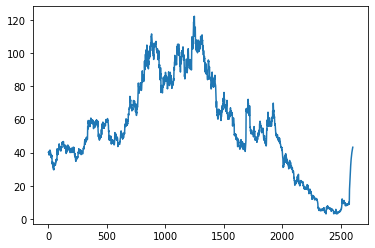

In [153]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)

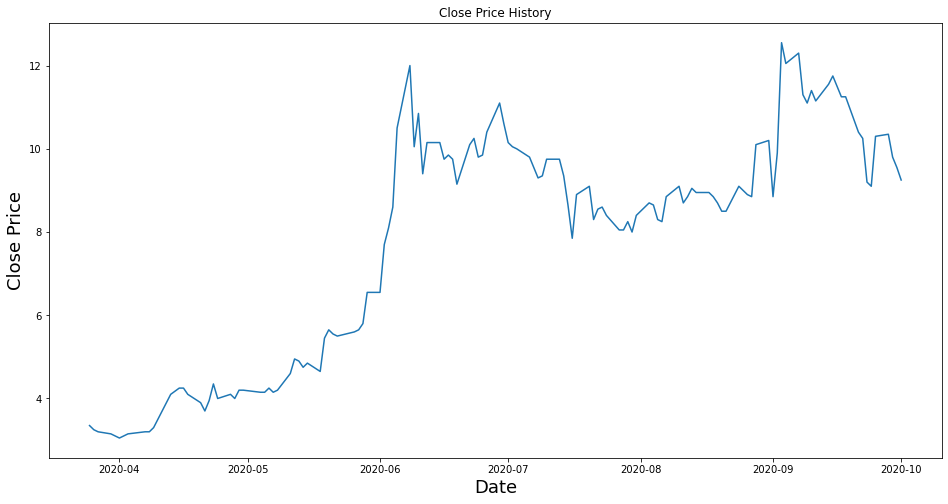

In [156]:
df2 = pdr.DataReader('IDEA.NS', data_source='yahoo', start='2020-03-25', end='2020-09-30')
#visualize the close price history
plt.figure(figsize=(16,8))
plt.title("Close Price History")
plt.plot(df2['Close'])
plt.xlabel('Date', fontsize =18)
plt.ylabel('Close Price', fontsize = 18)
plt.show()

**So we can see after 2020-06 the trend is high as predicted**